In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, math, random
import torch, torch_geometric
import jupyter_black

jupyter_black.load()


# Setting random state seeds
torch.manual_seed(1); 
random.seed(1)
np.random.seed(1)

# Load Data

In [2]:
from torch_geometric.datasets import IMDB
import torch_geometric.transforms as T

transform = T.ToUndirected()  # Add reverse edge types.
data = IMDB(root="./data/IMDB/", transform=transform)[0]

# Making the classification problem binary by merging class 2 and 1
data["movie"].y[data["movie"].y == 2] = 1

# Add edge attributes to all edges. The model expects edge attributes, and will produce error if it does not exist
for edge_type in data.edge_types:
    data[edge_type].edge_attr = torch.ones(
        [data[edge_type].edge_index.shape[1], 1], dtype=torch.float32
    )

# Reducing the number of features by removing those that are most frequently equal to zero
feature_mask = (data["movie"].x != 0).sum(dim=0) > 150
data["movie"].x = data["movie"].x[:, feature_mask]

feature_mask = (data["director"].x != 0).sum(dim=0) > 150
data["director"].x = data["director"].x[:, feature_mask]

feature_mask = (data["actor"].x != 0).sum(dim=0) > 400
data["actor"].x = data["actor"].x[:, feature_mask]

# Casting the reponse variable to float and reshaping it to match the exepcted dimension
data["movie"].y = data["movie"].y.reshape([len(data["movie"].y), 1]).to(torch.float32)

In [3]:
def draw(bool_array, draw_frac):
    """
    A helper function that draws indices from a boolean array where the elements are true,
    and returns an array of the same dimension where only the drawn indices are true
    Example:
        bool_array = [True True False True True]
        draw_frac = 0.50
        bool_array_new = [False True False True False]
    Input:
        bool_array : torch.bool array
        draw_frac :  float between 0 and 1
    Output:
        bool_array : torch.bool array
    """
    # Get array of indices where "bool_array == True"
    idx_true = bool_array.nonzero()[:, 0]
    # From the indices, we will draw "draw_frac" of them:
    num_draws = math.ceil(idx_true.shape[0] * draw_frac)
    idx_true_draws = idx_true[random.sample(range(0, idx_true.shape[0]), num_draws)]
    # We create a new boolean array which is True only at the drawn indices
    bool_array_new = torch.zeros(bool_array.shape[0], dtype=torch.bool)
    bool_array_new[idx_true_draws] = True
    return bool_array_new


def train_val_test_split(val_frac, test_frac, y):
    pos_mask = y == 1
    neg_mask = y == 0

    val_frac = val_frac
    test_frac = test_frac
    ## Creating test-mask ##
    pos_test = draw(pos_mask, test_frac)  # Drawing observations for y == 1
    neg_test = draw(neg_mask, test_frac)  # Drawing observations for y == 0
    test_mask = (pos_test) | (neg_test)
    ## Creating val-mask ##
    pos_val = draw(
        pos_mask & (~test_mask), val_frac / (1 - test_frac)
    )  # Drawing observations for y == 1
    neg_val = draw(
        neg_mask & (~test_mask), val_frac / (1 - test_frac)
    )  # Drawing observations for y == 0
    val_mask = (pos_val) | (neg_val)
    ## Creating train-mask ##
    train_mask = (pos_mask | neg_mask) & (~test_mask) & (~val_mask)
    return train_mask, val_mask, test_mask


(
    data["movie"].train_mask,
    data["movie"].val_mask,
    data["movie"].test_mask,
) = train_val_test_split(0.2, 0.2, data["movie"].y[:, 0])

# DEV

In [4]:
import importlib
import models_mpnn, models_hmct, utils

importlib.reload(models_hmct)
node_type = "movie"
max_epochs = 1000
model = models_mpnn.NNConv3Layer(data, node_type)
# model = models_hmct.Hmct1Layer(data, node_type)
utils.get_num_params(model)

/Users/fredrikjohannessen/opt/anaconda3/envs/pyg_playground/lib/python3.9/site-packages/torch_geometric/nn/conv/hetero_conv.py:62: UserWarning: There exist node types ({'actor', 'director'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behavior.
  warnings.warn(


5340

In [5]:
utils.get_num_params(model)

5340

/Users/fredrikjohannessen/opt/anaconda3/envs/pyg_playground/lib/python3.9/site-packages/torch_geometric/nn/conv/hetero_conv.py:62: UserWarning: There exist node types ({'director'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behavior.
  warnings.warn(
/Users/fredrikjohannessen/opt/anaconda3/envs/pyg_playground/lib/python3.9/site-packages/torch_geometric/nn/conv/hetero_conv.py:62: UserWarning: There exist node types ({'actor'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behavior.
  warnings.warn(
/Users/fredrikjohannessen/opt/anaconda3/envs/pyg_playground/lib/python3.9/site-packages/torch_geometric/nn/conv/hetero_conv.py:62: UserWarning: There exist node types ({'movie'}) whose representations do not get updated during message passing as they do not occur as destination type

Epoch #0
Epoch #25
Epoch #50
Epoch #75
Epoch #100
Epoch #125
Epoch #150
Epoch #175
Epoch #200
Epoch #225
Epoch #250
Epoch #275
Epoch #300
Epoch #325
Epoch #350
Epoch #375
Epoch #400
Epoch #425
Epoch #450
Epoch #475
Epoch #500
Early stopping. Epoch #516


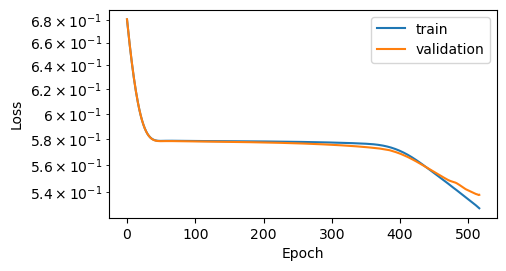

In [70]:
import models_mpnn, models_hmct, utils

node_type = "movie"
max_epochs = 10000

# Initialize model
# model = models_mpnn.NNConv3Layer(data, node_type)
model = models_hmct.Hmct3Layer(data, node_type)
utils.get_num_params(model)


train_hist = pd.DataFrame(columns=["loss_train", "loss_val"])

# Initialize the loss-function and optimizer
loss_fun = torch.nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-9)


y = data[node_type].y
# Training model with early stopping
model.train()
for epoch in range(max_epochs):
    optimizer.zero_grad()
    pred = model.forward(data.x_dict, data.edge_index_dict, data.edge_attr_dict)
    loss_train = loss_fun(
        pred[data[node_type].train_mask], y[data[node_type].train_mask]
    )

    loss_val = loss_fun(pred[data[node_type].val_mask], y[data[node_type].val_mask])

    train_hist.loc[epoch] = loss_train.item(), loss_val.item()
    if (
        epoch > 100
        and train_hist.loc[epoch, "loss_val"] > train_hist.loc[epoch - 1, "loss_val"]
    ):
        print(f"Early stopping. Epoch #{epoch}")
        break
    if epoch % 25 == 0:
        print(f"Epoch #{epoch}")

    loss_train.backward()
    optimizer.step()

train_hist

fig, ax = plt.subplots(figsize=(5, 2.7))
ax.plot(train_hist["loss_train"], label="train")
ax.plot(train_hist["loss_val"], label="validation")
ax.set_yscale("log")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.legend()
plt.show()

In [72]:
with torch.no_grad():
    pred = model.forward(data.x_dict, data.edge_index_dict, data.edge_attr_dict)

from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

pred_train = pred[data[node_type].train_mask].detach().numpy()
y_train = y[data[node_type].train_mask].detach().numpy()

pred_val = pred[data[node_type].val_mask].detach().numpy()
y_val = y[data[node_type].val_mask].detach().numpy()

pred_test = pred[data[node_type].test_mask].detach().numpy()
y_test = y[data[node_type].test_mask].detach().numpy()

print(roc_auc_score(y_train, pred_train))
print(roc_auc_score(y_val, pred_val))
print(roc_auc_score(y_test, pred_test))

0.7190677619509459
0.6923408248881169
0.7086873087132222


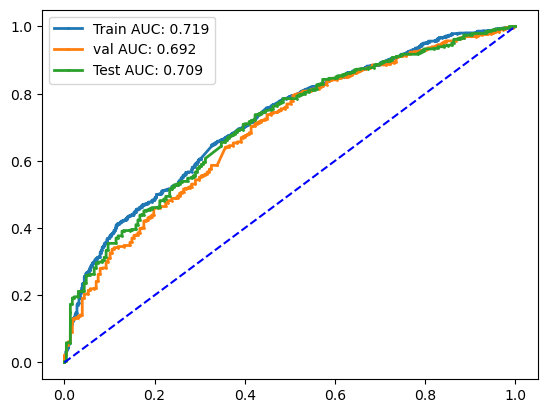

In [73]:
ms = 2
lw = 2
fpr_train, tpr_train, _ = roc_curve(y_train, pred_train)
fpr_val, tpr_val, _ = roc_curve(y_val, pred_val)
fpr_test, tpr_test, _ = roc_curve(y_test, pred_test)


def plot_curve(x, y, label):
    plt.plot(x, y, marker=".", markersize=ms, linewidth=lw, label=label)


plot_curve(fpr_train, tpr_train, f"Train AUC: {roc_auc_score(y_train, pred_train):.3f}")
plot_curve(fpr_val, tpr_val, f"val AUC: {roc_auc_score(y_val, pred_val):.3f}")
plot_curve(fpr_test, tpr_test, f"Test AUC: {roc_auc_score(y_test, pred_test):.3f}")


plt.plot([0, 1], [0, 1], linestyle="--", color="b")
plt.legend()
plt.show()